In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")

# raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")
dataset = raw_dataset.copy()

#examine missing data
# dataset.head()

2.5.0


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

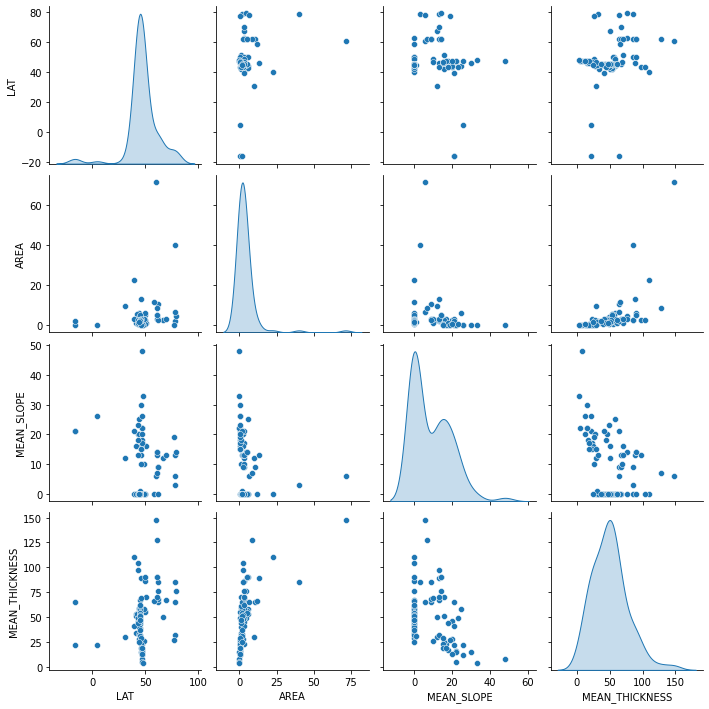

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


In [22]:
#begin linear regression with elevation

#put training features into numpy array and apply normalization layer
# array_int = np.array(train_features)
area = np.array(train_features["AREA"])
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)

In [36]:
#build elevation model with Sequential
area_model = tf.keras.Sequential([
    layers.Dense(1)
])
#     area_normalizer,

# area_model.summary()

In [44]:
#more pfm
area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [46]:
#run the actual model
#%%time
history_ele = area_model.fit(
    train_features["AREA"], train_labels,
    epochs=200,
    # suppress logging
#    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/200
3/3 [==============================] - 0s 15ms/step - loss: 31.9414 - val_loss: 39.0325
Epoch 2/200
3/3 [==============================] - 0s 6ms/step - loss: 31.6101 - val_loss: 38.3661
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 31.2494 - val_loss: 37.6861
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 30.8472 - val_loss: 37.1065
Epoch 5/200
3/3 [==============================] - 0s 5ms/step - loss: 30.5688 - val_loss: 36.6610
Epoch 6/200
3/3 [==============================] - 0s 5ms/step - loss: 30.3259 - val_loss: 36.2012
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 30.0556 - val_loss: 35.7839
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 29.7919 - val_loss: 35.4443
Epoch 9/200
3/3 [==============================] - 0s 5ms/step - loss: 29.5537 - val_loss: 35.0566
Epoch 10/200
3/3 [==============================] - 0s 5ms/step - loss: 29.3619 - val_loss: 34.6476
Epoch 11

3/3 [==============================] - 0s 5ms/step - loss: 19.8081 - val_loss: 24.0361
Epoch 84/200
3/3 [==============================] - 0s 6ms/step - loss: 19.7450 - val_loss: 23.8616
Epoch 85/200
3/3 [==============================] - 0s 6ms/step - loss: 19.6579 - val_loss: 23.5978
Epoch 86/200
3/3 [==============================] - 0s 5ms/step - loss: 19.5865 - val_loss: 23.3366
Epoch 87/200
3/3 [==============================] - 0s 6ms/step - loss: 19.5642 - val_loss: 23.1770
Epoch 88/200
3/3 [==============================] - 0s 5ms/step - loss: 19.5304 - val_loss: 23.0525
Epoch 89/200
3/3 [==============================] - 0s 5ms/step - loss: 19.5000 - val_loss: 22.9573
Epoch 90/200
3/3 [==============================] - 0s 5ms/step - loss: 19.4675 - val_loss: 22.8270
Epoch 91/200
3/3 [==============================] - 0s 5ms/step - loss: 19.4267 - val_loss: 22.7167
Epoch 92/200
3/3 [==============================] - 0s 6ms/step - loss: 19.3943 - val_loss: 22.6184
Epoch 93/200


3/3 [==============================] - 0s 6ms/step - loss: 17.3317 - val_loss: 20.6935
Epoch 165/200
3/3 [==============================] - 0s 5ms/step - loss: 17.3098 - val_loss: 20.6551
Epoch 166/200
3/3 [==============================] - 0s 5ms/step - loss: 17.2822 - val_loss: 20.7023
Epoch 167/200
3/3 [==============================] - 0s 5ms/step - loss: 17.2871 - val_loss: 20.7481
Epoch 168/200
3/3 [==============================] - 0s 6ms/step - loss: 17.2403 - val_loss: 20.7343
Epoch 169/200
3/3 [==============================] - 0s 5ms/step - loss: 17.2164 - val_loss: 20.6766
Epoch 170/200
3/3 [==============================] - 0s 6ms/step - loss: 17.1892 - val_loss: 20.5983
Epoch 171/200
3/3 [==============================] - 0s 5ms/step - loss: 17.1692 - val_loss: 20.5314
Epoch 172/200
3/3 [==============================] - 0s 5ms/step - loss: 17.1452 - val_loss: 20.4523
Epoch 173/200
3/3 [==============================] - 0s 6ms/step - loss: 17.1309 - val_loss: 20.4092
Epoc

In [13]:
hist_ele = pd.DataFrame(history_ele.history)
hist_ele['epoch'] = history_ele.epoch
hist_ele.tail()

,loss,val_loss,epoch
0,48.982368,56.238590,0
1,48.952541,56.210716,1


In [14]:
ele_test_results = {}

ele_test_results['elevation_model'] = area_model.evaluate(
    test_features['AREA'],
    test_labels, verbose=0)

ele_test_results['elevation_model']

56.465065002441406

In [15]:
# x = tf.linspace(0.0, 250, 251)
# y = elevation_model.predict(x)

predicted_thickness = area_model.predict(test_features['AREA'])

(0.0, 100.0)

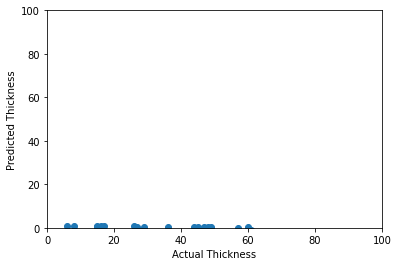

In [16]:
plt.subplots()
plt.plot(test_labels,predicted_thickness,'o')
plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.plot((-1,-1),(1,1),'-')
plt.xlim([0,100])
plt.ylim([0,100])

In [17]:
def plot_elevation(x, y):
    plt.scatter(train_features['AREA'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()

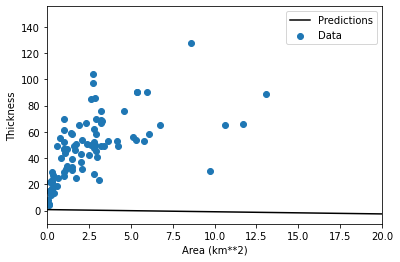

In [18]:
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_elevation(x,y)

In [19]:
#Linear regression with latitude

latitude = np.array(train_features['POINT_LAT'])

latitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
latitude_normalizer.adapt(latitude)


latitude_model = tf.keras.Sequential([
    latitude_normalizer,
    layers.Dense(units=1)
])

#latitude_model.summary()

latitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')



KeyError: 'POINT_LAT'

In [ ]:
%%time
history_lat = latitude_model.fit(
    train_features['POINT_LAT'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist_lat = pd.DataFrame(history_lat.history)
hist_lat['epoch'] = history.epoch
hist_lat.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['latitude_model'] = latitude_model.evaluate(
    test_features['POINT_LAT'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LAT'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
#Linear regression with longitude

longitude = np.array(train_features['POINT_LON'])

longitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
longitude_normalizer.adapt(latitude)


longitude_model = tf.keras.Sequential([
    longitude_normalizer,
    layers.Dense(units=1)
])

#longitude_model.summary()

longitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = longitude_model.fit(
    train_features['POINT_LON'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['longitude_model'] = longitude_model.evaluate(
    test_features['POINT_LON'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LON'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
#pfm function using multivariable regression

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

plot_loss(history)